## Pipeline explanation 

### (Input 1) example json file containing questions , model answers and keywords 

```
{
  "Q1": "What is a data structure",
  "Answer": "A data structure is for ... etc",
  "keywords": "[organize,graph,tree,queue,...etc]"
}
```

### (Input 2) The paths to audio files for candidate's answers

```
{
"path/to/audio/file/Q1.wav"
"path/to/audio/file/Q2.wav"
"path/to/audio/file/Q3.wav"
...
}
```

### Step 1 : Assert 
 1. Assert that lengths are matching (I.E no missing answers or something dropped)
 2. Assert that question numbers match


### Step 2 : Pass the audio files over the audio recognition sound model and generate key-value pairs {Q1:student_answer} 


### Step 3 : Calculate the TF-IDF score for each question {Q1:score}


### Step 4 ( To be postponed) : Generate the Feedback 

# Imports

In [1]:
from nltk.corpus import stopwords #=> stop words removal 
from collections import Counter
#from nltk import pos_tag #=> for defining part of speech 
from nltk.stem.porter import PorterStemmer #=> stemming word into its root
from nltk.stem.wordnet import WordNetLemmatizer #=> Lemmatizing variants of word to its original form
#from nltk.tokenize import word_tokenize , sent_tokenize #=> for tokenizing sentence
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
Extra_Stop_Words = {"the",",","a", "an", "and", "or", "in", "on", "to", "is", "are", "was", "were", "am", "i", "you", "he", "she", "it", "we", "they", "for", "of", "that", "this", "with", "as", "at", "by", "from", "up", "down", "out", "about", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"}
STOP_WORDS = set(stopwords.words("english"))
STOP_WORDS = STOP_WORDS.union(Extra_Stop_Words)
import json
import speech_recognition as sr
import os

## Class for audio recognition

In [2]:
class SoundRecorder:
    @staticmethod
    def get_answers(path_to_answers):
        answers = {}
        r = sr.Recognizer()
        answers_files = [os.path.join(path_to_answers,f) for f in os.listdir(path_to_answers) if f.endswith('.wav')]
        for audio in answers_files:
            sentence = ""
            #Use  the  reсоgnize_google()  funсtiоn  tо  reсоgnize  the  аudiо
            with sr.AudioFile(audio) as source:  
                audio_ans = r.record(source)
            try:
                sentence = r.recognize_google(audio_ans)
                # In order to take the question number only from the file name (1-9 questions)
                answers[audio[-6:-4]] = sentence
            except Exception as  e:
                print('Error:  ' + str(e))
        return answers

## Class AnswerEvaluator

In [3]:
class AnswerEvaluator:
    def __init__(self, model_answer, keywords,extra_stop_words=None,):
        self.model_answer = model_answer
        self.keywords = keywords
        self.STOP_WORDS = set(stopwords.words("english"))
        if extra_stop_words:
            self.STOP_WORDS = self.STOP_WORDS.union(set(extra_stop_words))
    
    def calculate_tf(self, document):
        tf = {}
        word_count = Counter(document)
        total_words = len(document)
        for word, count in word_count.items():
            tf[word] = count / total_words
        return tf

    def calculate_idf(self, documents):
        k=0.3
        total_documents = len(documents)
        all_words = set(word for document in documents for word in document)
        idf = {word: math.log((total_documents + k) / (1 + sum(1 for doc in documents if word in doc))) for word in all_words}
        return idf

    def calculate_tfidf(self, tf, idf):
        tfidf = {word: tf[word] * idf[word] for word in tf}
        return tfidf

    def cosine_similarity(self, vector1, vector2):
        dot_product = sum(vector1.get(word, 0) * vector2.get(word, 0) for word in set(vector1) & set(vector2))

        magnitude1 = math.sqrt(sum(value ** 2 for value in vector1.values()))
        magnitude2 = math.sqrt(sum(value ** 2 for value in vector2.values()))

        if magnitude1 != 0 and magnitude2 != 0:
            return dot_product / (magnitude1 * magnitude2)
        else:
            return 0

    def keyword_matching_score(self, student_answer, keywords):
        student_answer_lower = student_answer.lower()
        keywords_lower = [keyword.lower() for keyword in keywords]
        score = 0
        for keyword in keywords_lower:
            if keyword in student_answer_lower:
                score += 1
        if keywords_lower:
            score /= len(keywords_lower)
        return score

    def evaluate(self, student_answer, keywords):
        tokens1 = [word for word in self.model_answer.lower().split() if word not in self.STOP_WORDS]
        tokens2 = [word for word in student_answer.lower().split() if word not in self.STOP_WORDS]

        # lemmatize , then stem 
        #tokens1 = [PorterStemmer().stem(WordNetLemmatizer().lemmatize(word)) for word in tokens1]
        #tokens2 = [PorterStemmer().stem(WordNetLemmatizer().lemmatize(word)) for word in tokens2]

        documents = [tokens1, tokens2]
        tf1 = self.calculate_tf(tokens1)
        tf2 = self.calculate_tf(tokens2)
        idf = self.calculate_idf(documents)
        tfidf1 = self.calculate_tfidf(tf1, idf)
        tfidf2 = self.calculate_tfidf(tf2, idf)
        similarity_score = self.cosine_similarity(tfidf1, tfidf2)
        keywords_score = self.keyword_matching_score(student_answer, keywords)
        try :
            final_score = (similarity_score/keywords_score) * (similarity_score + keywords_score)/2
        except ZeroDivisionError:
            final_score = 0
        return 1 if final_score > 1 else final_score

## Class FeedbackGenerator

In [8]:
class FeedbackGenerator:
    @staticmethod
    def generate_feedback_message(scores):
        path_to_feedback_folder = "feedback samples/"
        feedback_message = "Thanks for completing the interview. Here's your feedback:\n"
        mappings = []
        areas = list(scores.keys())
        for _ , item in scores.items():
            if item < 0.5:
                mappings.append("low")
            elif item < 0.75:
                mappings.append("medium")
            else:
                mappings.append("high")
        
        for area , category in zip(areas,mappings):
            # shall be removed on higher integration
            try:
                path = path_to_feedback_folder + area + "/" + category + ".txt"
                with open(path, "r") as file:
                    messages = file.readlines()
                    # random choice of one message from the file
                    feedback_message += messages[np.random.randint(0,len(messages))] + "\n"
            except FileNotFoundError:
                raise FileNotFoundError("Feedback file not found")

        print(feedback_message)
        return
    
    @staticmethod
    def spider_graph_generator(scores):
    #split the dict into 2 lists
        scores_dict = scores
        scores = list(scores_dict.values())
        
        if max(scores) < 1:
            scores = [round(score,0)*100 for score in scores]
    
        scores_dict = list(scores_dict.keys())


        scores_dict_angles = np.linspace(0,2*np.pi,len(scores) , endpoint = False)
        scores_dict_angles = np.concatenate((scores_dict_angles, [scores_dict_angles[0]]))
        scores.append(scores[0])
        scores_dict.append(scores_dict[0])
        
        fig=plt.figure(figsize=(4,4))
        ax=fig.add_subplot(polar=True)
        #basic plot
        ax.plot(scores_dict_angles,scores, 'o--', color='g', linewidth=2, label='Scores')
        #fill plot
        ax.fill(scores_dict_angles, scores, alpha=0.25, color='g')
        #Add labels
        ax.set_thetagrids(scores_dict_angles * 180/np.pi, scores_dict)
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

## Class NLP_Module

In [5]:
class NLP_MODULE:
    def __init__(self,path_to_interviewee_answers:str,model_answers_json:str):
        self.path_to_interviewee_answers = path_to_interviewee_answers
        self.model_answers_json = model_answers_json
        self.questions_w_model_answers = {}
        self.interviewee_answers = {}
        self.results = {}

    def prepare_data(self):
        # Takes too long , need to be optimized by threading
        if self.model_answers_json is None or not self.model_answers_json.endswith("json"):
            raise TypeError("The file name is not in correct name or format , Make sure it's a json file")
        
        with open(self.model_answers_json, "r") as file:
            questions_w_model_answers = json.load(file)

        interviewee_answers = [f for f in os.listdir(self.path_to_interviewee_answers)]
        # Assert 1 
        assert len(questions_w_model_answers) == len(interviewee_answers),"Length Mismatch between audio files and answers provided"
        # Assert 2
        ans_no = lambda x : x[:-4]
        assert list(questions_w_model_answers.keys()) == list(map(ans_no,interviewee_answers)) , "Keys Mismatch among questions' numbers"
        del ans_no 
        self.interviewee_answers = SoundRecorder.get_answers(self.path_to_interviewee_answers)
        self.questions_w_model_answers = dict(sorted(questions_w_model_answers.items()))
        return self.questions_w_model_answers,self.interviewee_answers

    def generate_results(self):
        results = {}
        for ques_no, answer in self.questions_w_model_answers.items():
            model_answer = answer['model_answer']
            keywords = answer['hint_keywords']
            # print(f"Model Answer : {answer['model_answer']} \n Keywords: {answer['hint_keywords']}")
            a_evaluator = AnswerEvaluator(model_answer, keywords)
            for q_no, ans in self.interviewee_answers.items():
                if q_no == ques_no:
                    results[q_no] = a_evaluator.evaluate(ans, keywords)
        print("Scores for each question ...  ")
        print(results)
        self.results["technical"] = np.mean(list(results.values()))
        self.results["personal"] = np.random.random()
        self.results["social"] = np.random.random()
        print(self.results)
        FeedbackGenerator.generate_feedback_message(self.results)
        FeedbackGenerator.spider_graph_generator(self.results)
    
    def export_results_to_json(self):
        with open("results.json", "w") as file:
            json.dump(self.results,file,indent=4)

# Trials Solo

In [6]:
# # read questions.json 
# with open("questions.json", "r") as file:
#     questions = json.load(file)

# interviewees_answers = [f for f in os.listdir("audio samples/interviewee_answer")]

# # Assert 1 
# assert len(questions) == len(interviewees_answers)
# # Assert 2
# ans_no = lambda x : x[:-4]
# assert list(questions.keys()) == list(map(ans_no,interviewees_answers))

# questions = dict(sorted(questions.items()))
# questions
# s_recorder = SoundRecorder("audio samples/interviewee_answer")
# answers = s_recorder.get_answers()
# answers
# results = {}
# for ques_no, answer in questions.items():
#     model_answer = answer['model_answer']
#     keywords = answer['hint_keywords']
#     # print(f"Model Answer : {answer['model_answer']} \n Keywords: {answer['hint_keywords']}")
#     a_evaluator = AnswerEvaluator(model_answer, keywords)
#     for q_no, ans in answers.items():
#         #print(model_answer,ans)
#         if q_no == ques_no:
#             # print(q_no,ques_no)
#             results[q_no] = a_evaluator.evaluate(ans, keywords)

#     # f_generator = FeedbackGenerator(results)
#     # print(f_generator.generate_feedback_message())
#     # f_generator.spider_graph_generator()

# print(results)
# to_fb_generator = {"technical":np.mean(list(results.values())) , "social":np.random.random() , "personal":np.random.random()}
# print(to_fb_generator)

# f_generator = FeedbackGenerator(to_fb_generator)
# print(f_generator.generate_feedback_message())
# f_generator.spider_graph_generator()

# Integration Test

Scores for each question ...  
{'Q1': 1, 'Q2': 1, 'Q3': 1, 'Q4': 0, 'Q5': 1}
{'technical': 0.8, 'personal': 0.9846542610829965, 'social': 0.7261115751567833}
Thanks for completing the interview. Here's your feedback:
Your proficiency in handling complex technical challenges was remarkable, reflecting your strong foundation in the subject matter.
Your excellent presentation skills and ability to communicate ideas effectively were evident throughout the interview.

While your social skills are decent, there is room for improvement in terms of fostering stronger connections and collaboration.




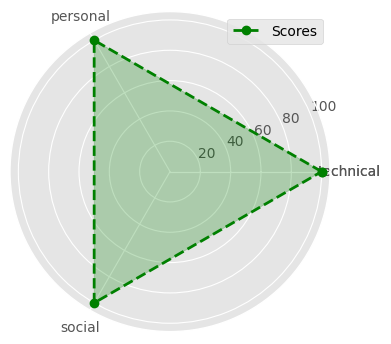

In [9]:
nlp_class_module = NLP_MODULE("audio samples/interviewee_answer" , "questions.json")
nlp_class_module.prepare_data()
nlp_class_module.generate_results()
nlp_class_module.export_results_to_json()